Практическое задание:


- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

- сделать обзорный анализ выбранного датасета
- сделать feature engineering

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('adult.csv')
categorial_features = ['State-gov', 'Bachelors', 'Never-married', 'Adm-clerical', 'Not-in-family', 'White', 'Male', 'United-States']
normal_values = []

for value in df[' <=50K']:
    if value == " <=50K":
        normal_values.append(0)
    if value == " >50K":
        normal_values.append(1)
        
df[' <=50K'] = normal_values
df = pd.get_dummies(df, prefix=categorial_features)
df.head(5)

,39,77516,13,2174,0,40,<=50K,State-gov_ ?,State-gov_ Federal-gov,State-gov_ Local-gov,...,United-States_ Portugal,United-States_ Puerto-Rico,United-States_ Scotland,United-States_ South,United-States_ Taiwan,United-States_ Thailand,United-States_ Trinadad&Tobago,United-States_ United-States,United-States_ Vietnam,United-States_ Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Обзорный анализ:

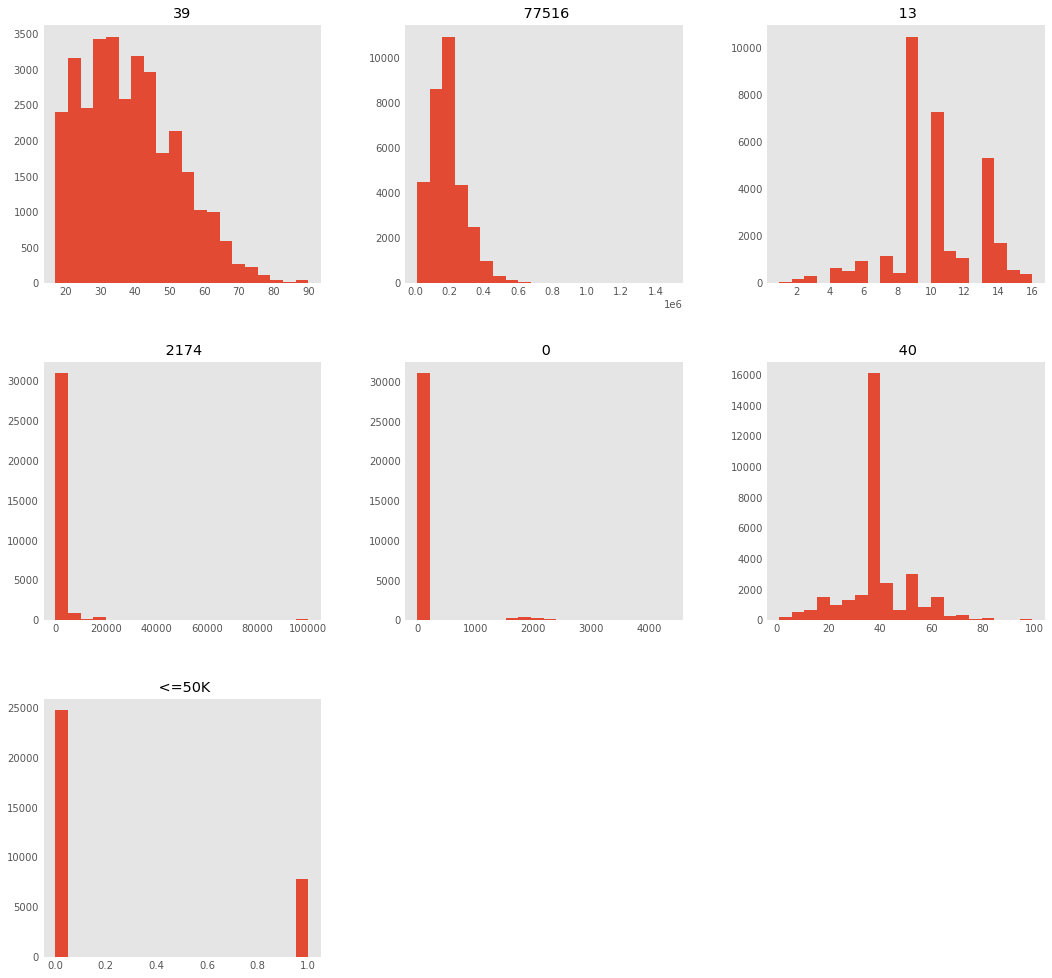

In [18]:
plt.style.use('ggplot')
df_num_features = df.select_dtypes(include=['float64', 'float32','float32', 'float16','int8','int16','int64','int32'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Это датасет по доходам американцев, нужно классифицировать он больше 50к или меньше на основе данных о человеке

- обучить любой классификатор (какой вам нравится)

In [19]:
X = df.drop(columns=[' <=50K'])
y = df[' <=50K']

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cbr_final_model = CatBoostClassifier(
    **params_model,
    depth=8,
    iterations=100,
    learning_rate=0.5
)

cbr_final_model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_predict = cbr_final_model.predict(X_test)

In [21]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_predict)

Classification results:
f1: 71.68%
roc: 84.98%
recall: 88.14%
precision: 60.40%


In [27]:
df2 = pd.read_csv('adult.csv')

df2.head(5)

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%

Тут названия половины фич неизвестны, поэтому попробую интерпретировать то, что известно. Возьмем Male (это пол) и White (цвет кожи). 1 это если доход ~>50k, 0 если меньше

Значит, то, что человек черный понижает его шансы на получение дохода выше ~>50k в данном случае.
В свою очередь если человек это женщина - то сильной корреляции нету, но оно колеблится возле нуля, то есть женский пол не дает преимуществ в плане доходов. 
В свою очередь мужской пол идет от обратного - очень много значений с малым доходом, которые снижают вероятность попасть в выборку "1". Но самый важный тут признак 2174 - я не знаю, что он значит. Он был в изначальном датасете и не объясняется. Видимо, принадлежность к семейству Рокфелеров. Что касаемо тех, кто никогда не женился - это также снижает вероятность попадания в выборку для модели. Хм. Судя по всему признак 2174 это принадлежность к определенному округу. Он повышает шанс на высокий доход. 

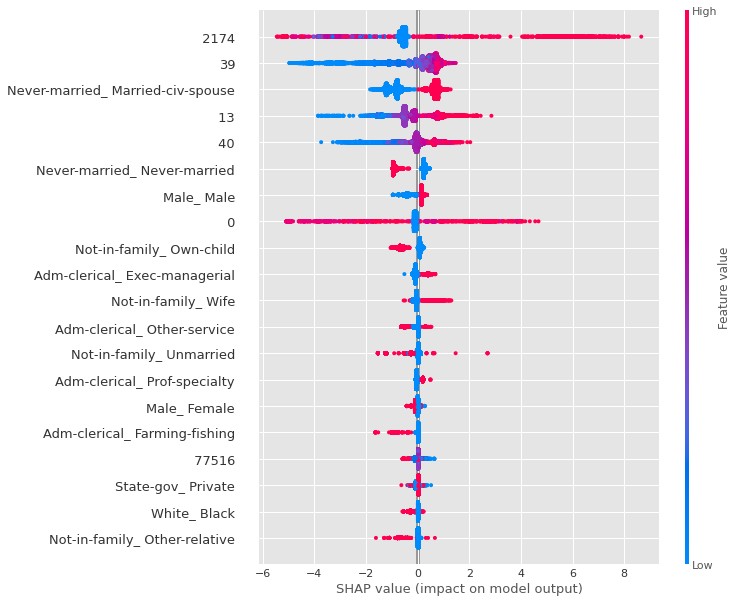

In [26]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

In [22]:
explainer = shap.TreeExplainer(cbr_final_model)
shap_values = explainer.shap_values(X_train)

- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ну а что тут интерпретировать? Всё итак ясно. На глазах у нас человек который никогда не женился, мужчина. Вот он и попадает в выборку с нулем, то есть его доход по мнению модели меньше 50к. Остальные фичи сложно интерпретировать, т.к. они не описаны

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])